# Shopper Spectrum: Customer Segmentation and Product Recommendations in E-Commerce

## Github Link for this Project :
#### https://github.com/shabbu8111999/Shopper_Spectrum_Customer_Segmentation

## Problem Statement

### This project aims to examine transaction data from an online retail business to uncover patterns in customer purchase behavior, segment customers based on Recency, Frequency, and Monetary (RFM) analysis, and develop a product recommendation system using collaborative filtering techniques.

In [53]:
import os

In [54]:
# Gets the absolute path of the parent directory
os.path.abspath(os.path.join('../'))

'c:\\Users\\H P\\Desktop\\Shopper_Spectrum_Customer_Segmentation'

# Importing required Libraries

In [55]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing & Models
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Hierarchical Clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Similarity Measures for Recommendation
from sklearn.metrics.pairwise import cosine_similarity

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Loading the Dataset

In [56]:
# Load the dataset
df = pd.read_csv('../data/raw/online_retail.csv', encoding = 'latin1')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2023-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2023-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2023-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2023-12-09 12:50:00,4.15,12680.0,France


# Dataset overview

In [57]:
# Checking the shape of the dataset
df.shape

(541909, 8)

In [58]:
# checking the first few rows of the dataset
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2022-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2022-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2022-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2022-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2022-12-01 08:34:00,1.69,13047.0,United Kingdom


In [59]:
# checking the last few rows of the dataset
df.tail(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541899,581587,22726,ALARM CLOCK BAKELIKE GREEN,4,2023-12-09 12:50:00,3.75,12680.0,France
541900,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,2023-12-09 12:50:00,3.75,12680.0,France
541901,581587,22367,CHILDRENS APRON SPACEBOY DESIGN,8,2023-12-09 12:50:00,1.95,12680.0,France
541902,581587,22629,SPACEBOY LUNCH BOX,12,2023-12-09 12:50:00,1.95,12680.0,France
541903,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,2023-12-09 12:50:00,4.15,12680.0,France
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2023-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2023-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2023-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2023-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2023-12-09 12:50:00,4.95,12680.0,France


In [60]:
# checking the info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [61]:
# displaying basic statistics of the dataset
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Data Cleaning

In [62]:
# Before cleaning the data i will create a copy of the original dataframe
df_clean = df.copy()

In [63]:
# checking for missing values
df_clean.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [64]:
# removing the rows with missing CustomerID
df_clean = df_clean.dropna(subset=["CustomerID"])

# Filling out the missing values in 'Description' with 'Unknown'
df_clean['Description'] = df_clean['Description'].fillna('Unknown')

In [65]:
# checking the data after handling missing values
df_clean.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [66]:
print(df_clean.columns.to_list())

['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


In [67]:
# Removing the cancelled invoices number
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('c', na=False)]

In [68]:
# Removing the invalid quantities and prices
df_clean = df_clean[(df_clean["Quantity"] > 0) & (df_clean["UnitPrice"] > 0)]

In [69]:
# Comparing the shape of the cleaned dataset with the original dataset
print(f"Cleaned dataset shape: {df_clean.shape}")
print(f"Original dataset shape: {df.shape}")

Cleaned dataset shape: (397884, 8)
Original dataset shape: (541909, 8)


# Feature Engineering

In [70]:
# Converting 'InvoiceDate' to datetime format
df_clean["InvoiceDate"] = pd.to_datetime(df_clean["InvoiceDate"])

# Creating a new column 'TotalAmount' as Quantity * UnitPrice
df_clean["TotalAmount"] = df_clean["Quantity"] * df_clean["UnitPrice"]

df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


# Exploratory Data Analysis

## Transactions by Country

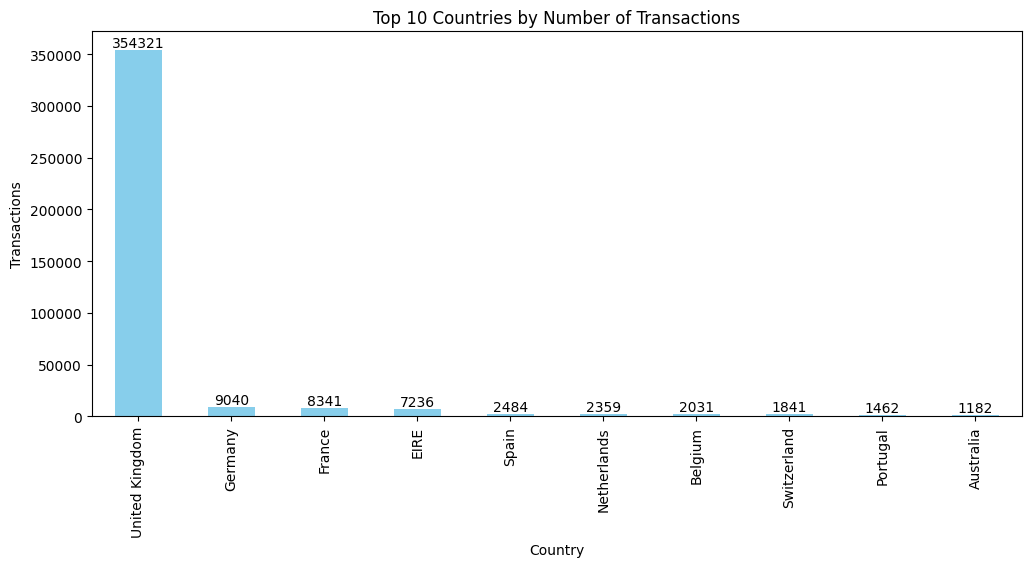

In [71]:
# Trabsactions by Country

ax = df_clean["Country"].value_counts().head(10).plot(
    kind='bar', figsize=(12, 5), color='skyblue'
)

for c in ax.containers:
    ax.bar_label(c)

plt.title("Top 10 Countries by Number of Transactions")
plt.ylabel("Transactions")
plt.show()

### The business is strongly UK-centric, which provides stability but also creates dependency risk. Expanding into other active countries can improve growth and reduce long-term risk.

## Top Selling Products

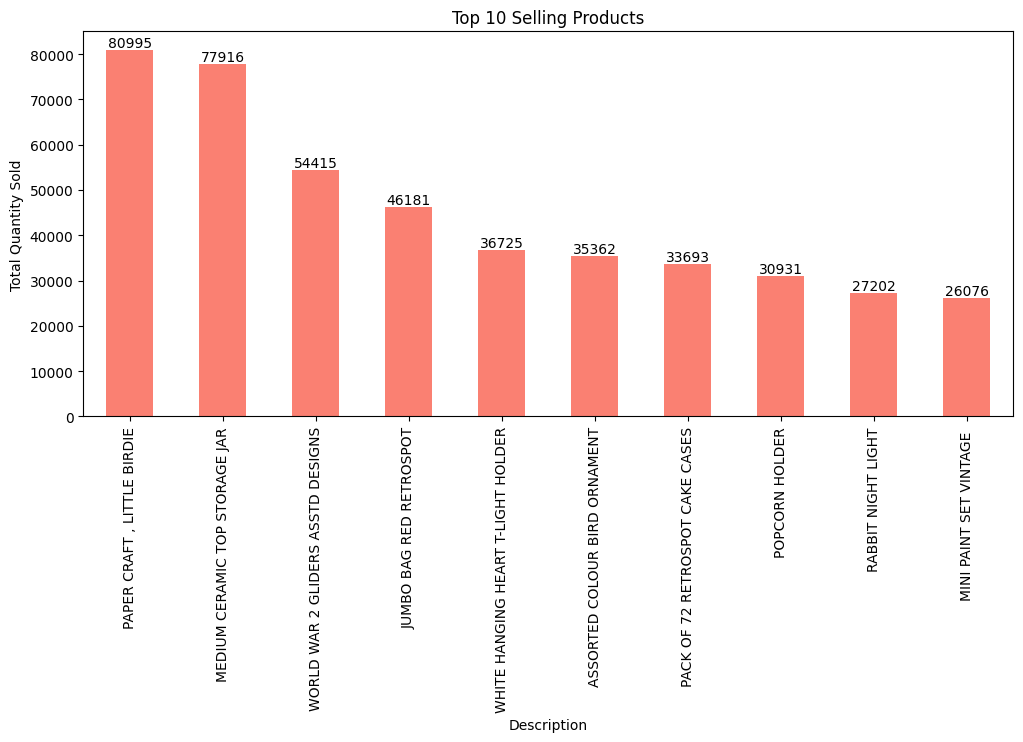

In [72]:
# Top Selling Products
ax = df_clean.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10).plot(
    kind = "bar", figsize=(12,5), color='salmon'
)

for c in ax.containers:
    ax.bar_label(c)


plt.title("Top 10 Selling Products")
plt.ylabel("Total Quantity Sold")
plt.show()

### A small set of products drives most of the sales, indicating strong customer preference for these items. While this ensures stable revenue, it also creates dependency risk if these products become unavailable.

## Monthly Purchase trends

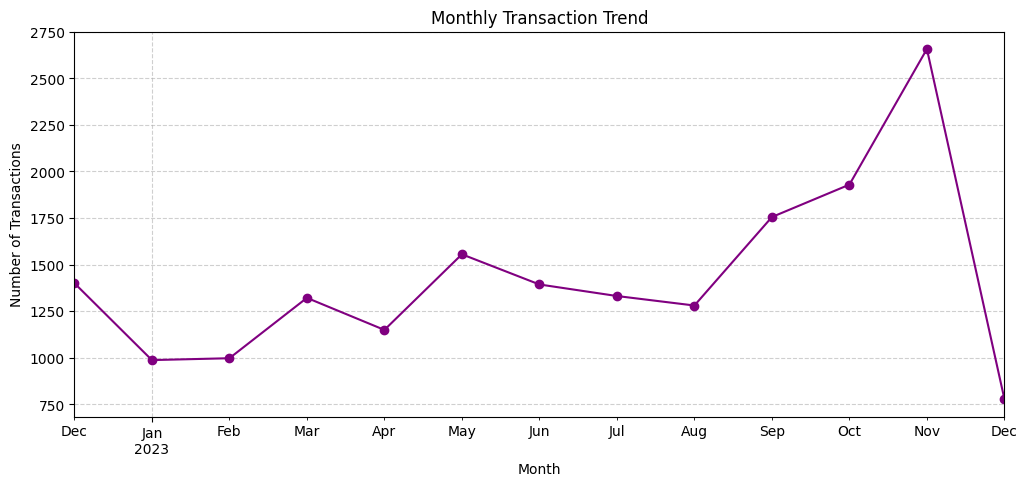

In [73]:
# Monthly Purchase trends

ax = (
    df_clean.set_index("InvoiceDate").resample("M")["InvoiceNo"].nunique().plot(
        figsize=(12,5), marker='o', color='purple'
    )
)

plt.title("Monthly Transaction Trend")
plt.ylabel("Number of Transactions")
plt.xlabel("Month")
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

### Transaction activity shows a clear seasonal trend, with higher sales toward the end of the year. This helps the business plan inventory and promotions more effectively.

## Quantity vs Unit Price (Outlier Detection)

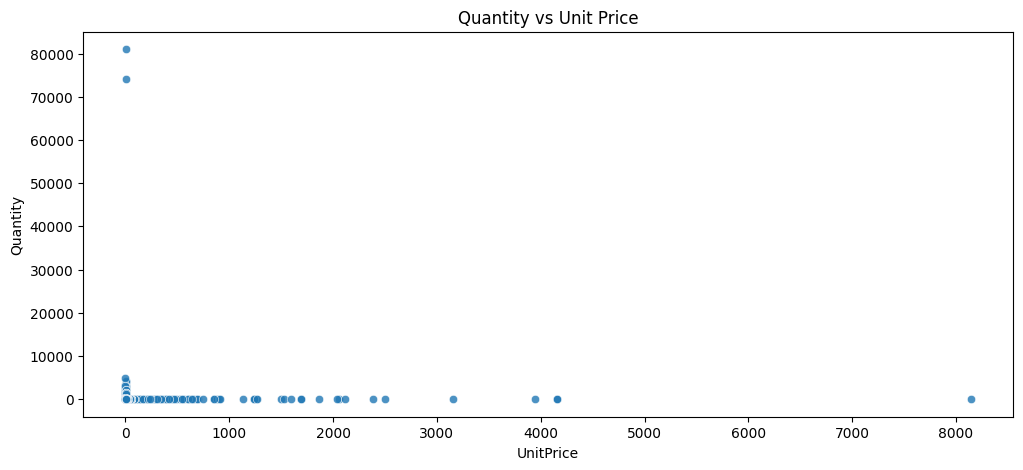

In [74]:
plt.figure(figsize=(12,5))
sns.scatterplot(
    data=df_clean,
    x="UnitPrice",
    y="Quantity",
    alpha=0.8
)
plt.title("Quantity vs Unit Price")
plt.show()

### The plot shows that most sales come from low-priced products sold in higher quantities, while expensive products sell infrequently. Extreme values indicate outliers that need cleaning before analysis.

## Customer Purchase Frequency Distribution

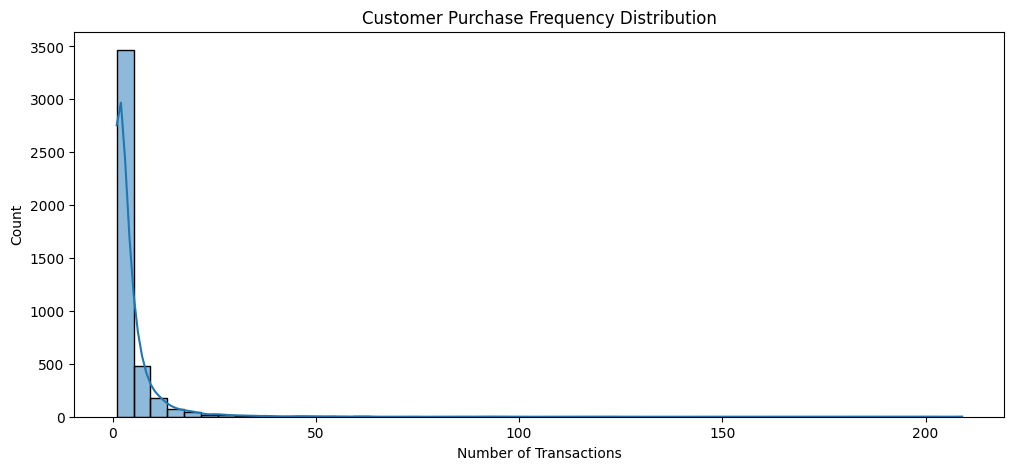

In [75]:
customer_freq = df_clean.groupby("CustomerID")["InvoiceNo"].nunique()

plt.figure(figsize=(12,5))
sns.histplot(customer_freq, bins=50, kde=True)
plt.title("Customer Purchase Frequency Distribution")
plt.xlabel("Number of Transactions")
plt.show()


### The purchase frequency distribution shows that most customers buy only once or twice, while a small group makes frequent purchases. This highlights the importance of customer retention strategies.

## Revenue Contribution By Top 10 Countries

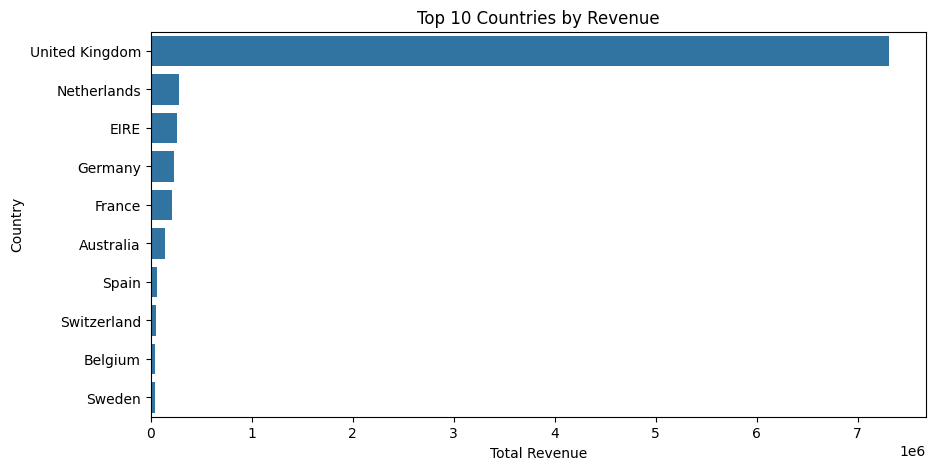

In [76]:
df_clean["Revenue"] = df_clean["Quantity"] * df_clean["UnitPrice"]

country_revenue = (
    df_clean.groupby("Country")["Revenue"].sum().sort_values(ascending=False).head(10)
)

plt.figure(figsize=(10,5))
sns.barplot(x=country_revenue.values, y=country_revenue.index)
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Total Revenue")
plt.show()

### Revenue is heavily concentrated in the United Kingdom, while other countries contribute marginally. This indicates strong domestic performance but also highlights the need for international expansion.

## Invoice Size Distribution (Items Per Invoice)

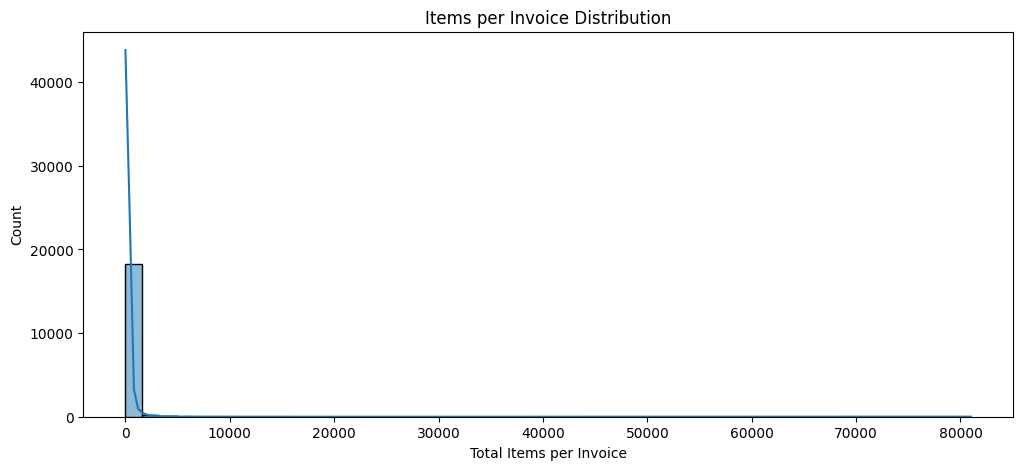

In [77]:
invoice_size = df_clean.groupby("InvoiceNo")["Quantity"].sum()

plt.figure(figsize=(12,5))
sns.histplot(invoice_size, bins=50, kde=True)
plt.title("Items per Invoice Distribution")
plt.xlabel("Total Items per Invoice")
plt.show()


### Most invoices contain only a few items, indicating small basket sizes. A small number of very large orders create a long tail and should be treated separately in analysis.

## Monetary per Transaction Distribution

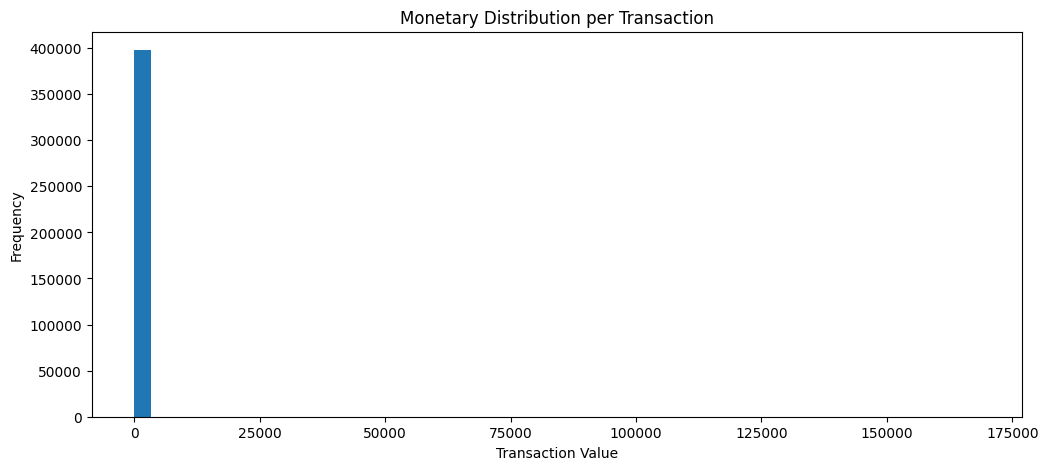

In [78]:
# Monetary per Transaction Distribution

df_clean["TotalPrice"] = df_clean["Quantity"] * df_clean["UnitPrice"]

plt.figure(figsize=(12,5))
plt.hist(df_clean["TotalPrice"], bins=50)
plt.title("Monetary Distribution per Transaction")
plt.xlabel("Transaction Value")
plt.ylabel("Frequency")
plt.show()


### Most transactions are low in value, while a small number of high-value transactions create a long tail. This indicates a volume-driven revenue model.

## Monetary per Customer Distribution

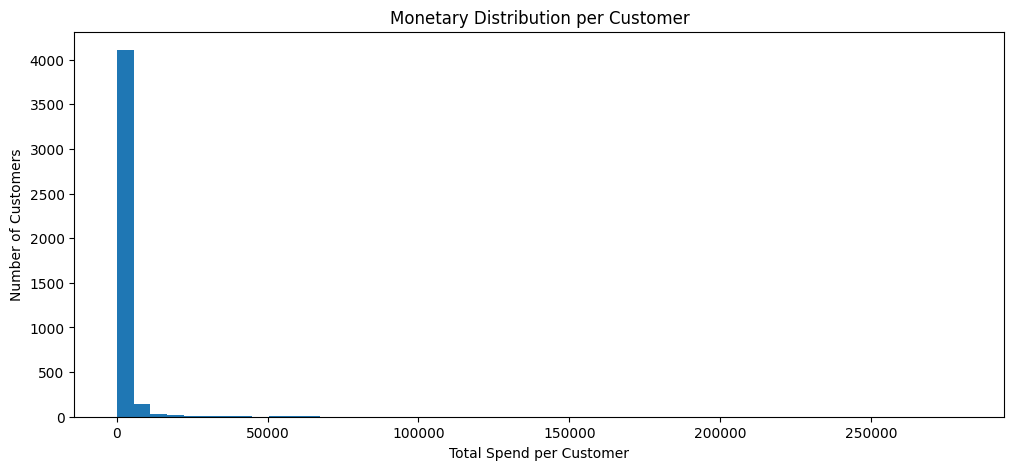

In [79]:
# Monetary per Customer Distribution

customer_monetary = df_clean.groupby("CustomerID")["TotalPrice"].sum()

plt.figure(figsize=(12,5))
plt.hist(customer_monetary, bins=50)
plt.title("Monetary Distribution per Customer")
plt.xlabel("Total Spend per Customer")
plt.ylabel("Number of Customers")
plt.show()

### Most customers have low total spending, while a small group of high-value customers contribute disproportionately to revenue. This highlights the importance of customer segmentation and retention.

## Creating a RFM Table

In [80]:
# Creating RFM Table

snapshot_date = df_clean["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df_clean.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


## Visualizing RFM Distributions

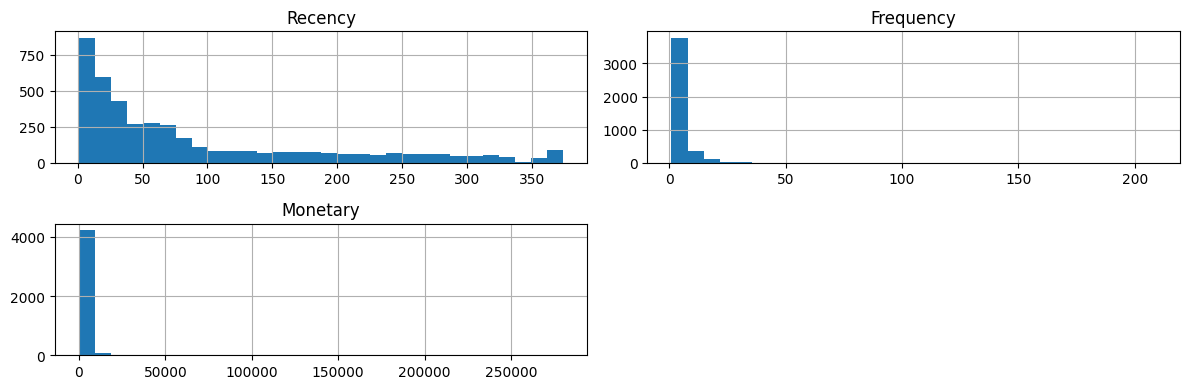

In [81]:
# Visualizing RFM Distributions

rfm.hist(figsize=(12,4), bins=30)
plt.tight_layout()
plt.show()

### RFM distributions show that most customers purchase infrequently and spend less, while a small group of recent, frequent, and high-spending customers contribute most of the revenue. This highlights the need for customer segmentation and targeted retention strategies.

In [82]:
# Scaling RFM Values

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

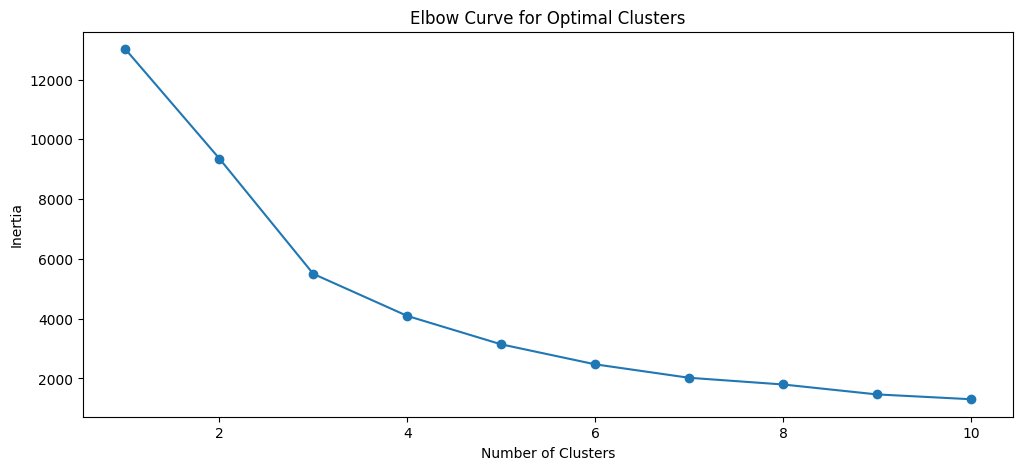

In [83]:
# Elbow Method to find optimal K

inertia = []

for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(12,5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Curve for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

### The elbow curve indicates that around 3 to 4 clusters provide a good balance between model simplicity and accuracy, making customer segments meaningful and actionable.

In [84]:
# fitting KMeans with optimal clusters
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [85]:
# Cluster Profile Table
cluster_profile = rfm.groupby("Cluster").mean()
cluster_profile

,Recency,Frequency,Monetary
Cluster,,,
0,43.702685,3.682711,1359.049284
1,248.075914,1.552015,480.617480
2,7.384615,82.538462,127338.313846
3,15.500000,22.333333,12709.090490


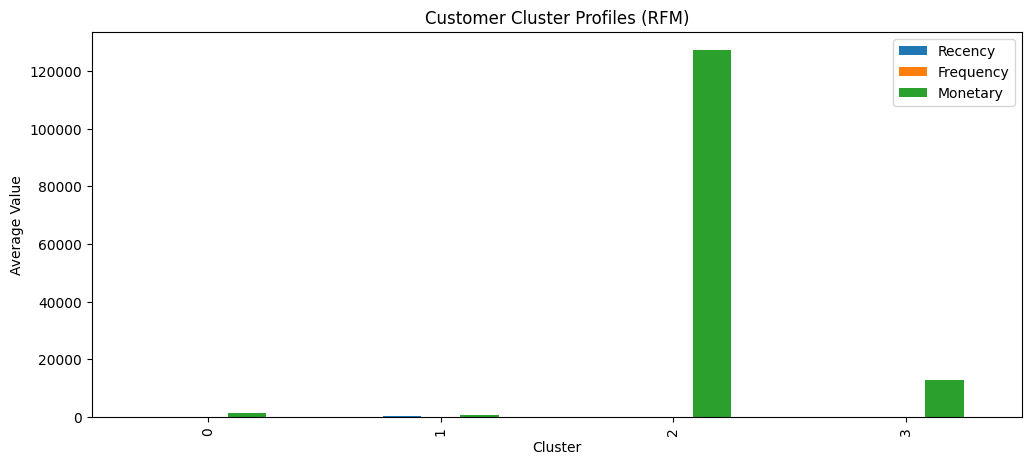

In [86]:
# Visualizing Cluster Comparison

cluster_profile.plot(kind="bar", figsize=(12,5))
plt.title("Customer Cluster Profiles (RFM)")
plt.ylabel("Average Value")
plt.show()


### RFM clustering separates customers into distinct behavioral groups, clearly identifying high-value customers, churn-risk customers, and growth opportunities.

## Product Recommendation Heatmap / Similarity matrix

In [87]:
# Creating Customer-Product Matrix

customer_product = df_clean.pivot_table(
    index="CustomerID",
    columns="Description",
    values="Quantity",
    fill_value=0
)
customer_product.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
# Compute cosine similarity between products and store it in a DataFrame

product_similarity = cosine_similarity(customer_product.T)
similarity_df = pd.DataFrame(
    product_similarity,
    index=customer_product.columns,
    columns=customer_product.columns
)
similarity_df.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
Description,,,,,,,,,,,,,,,,,,,,,
4 PURPLE FLOCK DINNER CANDLES,1.000000,0.000000,0.000106,0.000494,0.000000,0.000000,0.031646,0.000000,0.000272,0.134742,...,0.0,0.002012,0.028527,0.002462,0.0,0.005989,0.0,0.039433,0.00000,0.001852
50'S CHRISTMAS GIFT BAG LARGE,0.000000,1.000000,0.009123,0.004511,0.000000,0.020504,0.016754,0.918930,0.145846,0.008422,...,0.0,0.001864,0.021446,0.011945,0.0,0.014968,0.0,0.010439,0.00000,0.031379
DOLLY GIRL BEAKER,0.000106,0.009123,1.000000,0.536172,0.728505,0.017890,0.005196,0.007484,0.002644,0.186663,...,0.0,0.000174,0.009784,0.367785,0.0,0.251604,0.0,0.455050,0.00036,0.015561
I LOVE LONDON MINI BACKPACK,0.000494,0.004511,0.536172,1.000000,0.705221,0.025421,0.001527,0.004645,0.007066,0.172236,...,0.0,0.001621,0.008273,0.353233,0.0,0.239391,0.0,0.453407,0.00000,0.016661
I LOVE LONDON MINI RUCKSACK,0.000000,0.000000,0.728505,0.705221,1.000000,0.000000,0.000000,0.000000,0.000000,0.213768,...,0.0,0.000000,0.000000,0.490886,0.0,0.330277,0.0,0.615980,0.00000,0.000000


In [89]:
# Selecting the first product name and get top 5 most similar products (excluding itself)
product_name = similarity_df.columns[0]

similarity_df[product_name].sort_values(ascending=False)[1:6]

Description
4 PINK DINNER CANDLE SILVER FLOCK    0.843391
BLACK MINI TAPE MEASURE              0.418047
PINK DIAMANTE PEN IN GIFT BOX        0.368003
LETTER "I" BLING KEY RING            0.296621
PINK/FLOWER RABBIT EGG WARMER        0.273471
Name:  4 PURPLE FLOCK DINNER CANDLES, dtype: float64

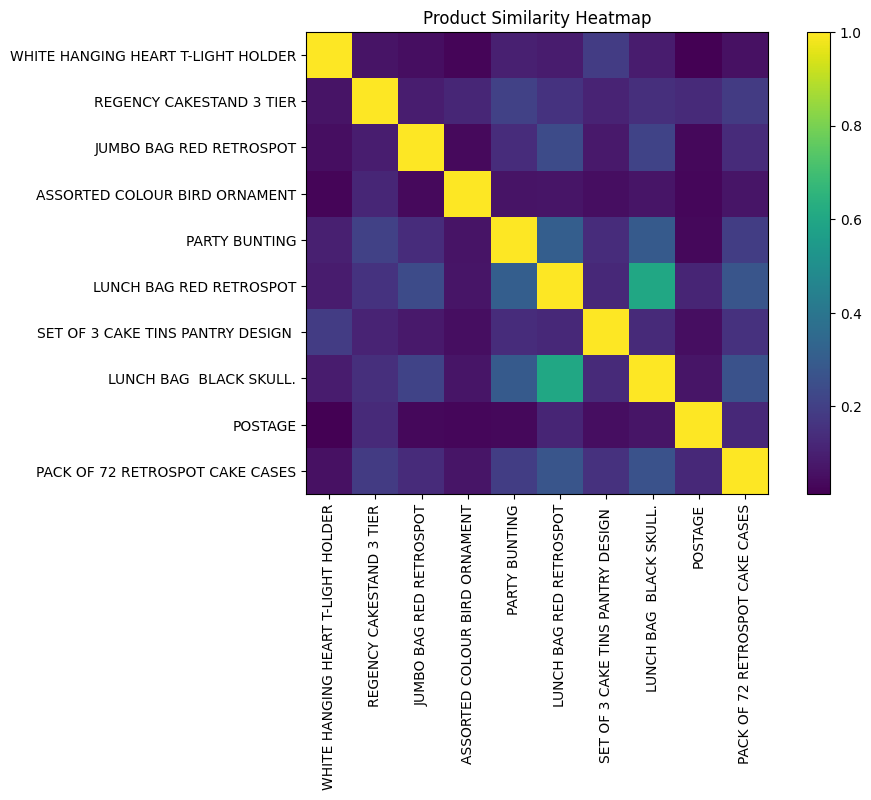

In [90]:
# Heatmaps of Top Products

top_products = df_clean["Description"].value_counts().head(10).index
top_similarity = similarity_df.loc[top_products, top_products]

plt.figure(figsize=(10,6))
plt.imshow(top_similarity)
plt.colorbar()
plt.xticks(range(len(top_products)), top_products, rotation=90)
plt.yticks(range(len(top_products)), top_products)
plt.title("Product Similarity Heatmap")
plt.show()

### The product similarity heatmap shows which products are frequently purchased together, helping identify strong cross-selling and recommendation opportunities.

In [91]:
# Applying DBSCAN clustering and assign the cluster labels to each customer
dbscan = DBSCAN(eps=0.8, min_samples=5)
rfm["DBSCAN_Cluster"] = dbscan.fit_predict(rfm_scaled)

rfm["DBSCAN_Cluster"].value_counts()

DBSCAN_Cluster
 0    4297
-1      41
Name: count, dtype: int64

### DBSCAN identified one main cluster of similar customers and a small set of outliers. This shows that DBSCAN is better suited for outlier detection in this dataset rather than detailed customer segmentation.

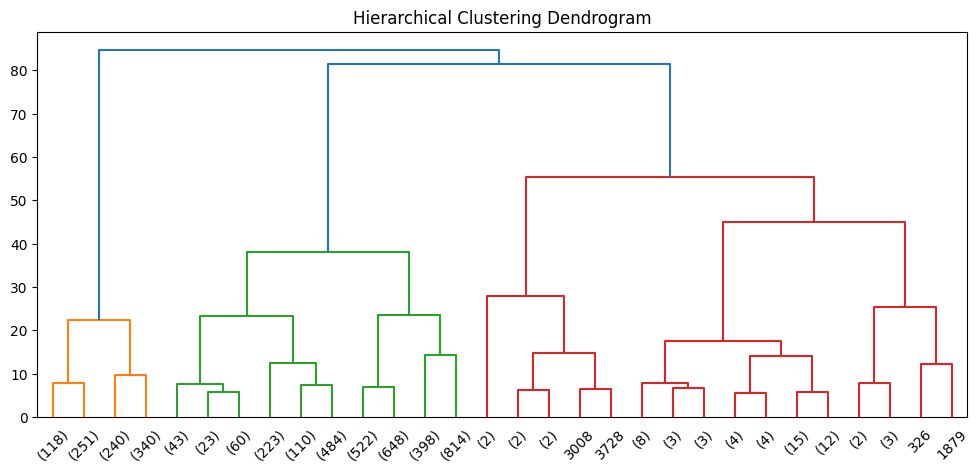

In [92]:
# Performed hierarchical clustering using Ward’s method and visualize it as a dendrogram
linked = linkage(rfm_scaled, method="ward")

plt.figure(figsize=(12,5))
dendrogram(linked, truncate_mode="lastp", p=30)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()


### The dendrogram shows natural groupings of customers based on purchasing behavior and confirms that around 3 to 4 clusters are meaningful.

In [93]:
# Calculating the average RFM values for each cluster
rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean()

,Recency,Frequency,Monetary
Cluster,,,
0,43.702685,3.682711,1359.049284
1,248.075914,1.552015,480.617480
2,7.384615,82.538462,127338.313846
3,15.500000,22.333333,12709.090490


In [94]:
#from sklearn.metrics import silhouette_score

# KMeans Silhouette Score
kmeans_score = silhouette_score(rfm_scaled, rfm["Cluster"])

# DBSCAN Silhouette Score
dbscan_labels = rfm["DBSCAN_Cluster"]

if len(set(dbscan_labels)) > 1:
    dbscan_score = silhouette_score(rfm_scaled, dbscan_labels)
else:
    dbscan_score = "Not Applicable"

print("Silhouette Scores")
print("KMeans :", kmeans_score)
print("DBSCAN :", dbscan_score)


Silhouette Scores
KMeans : 0.616212846765192
DBSCAN : 0.8634068574759618


### Conclusion:
#### DBSCAN performs better than KMeans for this data, as it has a much higher silhouette score, indicating clearer and more well-separated customer clusters.